(ch:fits_basic)=
# Basics about FITS

This part will teach you:

1. Read/write FITS files.
2. Crop (cutout) a small region of the FITS image.

In [1]:
# Ignore this cell if you encounter errors
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-04-17 21:07:28 (KST = GMT+0900) 
0 Python     3.10.10 64bit [Clang 14.0.6 ]
1 IPython    8.7.0
2 OS         macOS 13.1 arm64 arm 64bit
3 astropy    5.2.2
4 numpy      1.23.2
5 scipy      1.10.1
6 matplotlib 3.7.1
7 version_information 1.0.4


In [3]:
# %matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()

from pathlib import Path
import numpy as np

from astropy.io import fits
from astropy.time import Time
from astropy import units as u
from astropy.nddata import CCDData

from matplotlib import pyplot as plt
from matplotlib import rcParams

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

plt.style.use('default')
rcParams.update({'font.size':12})

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

import _tool_visualization as vis

DATAPATH = Path('../../../Tutorial_Data')
TMPDIR = Path('tmp')
TMPDIR.mkdir(exist_ok=True)

In [4]:
allfits = list(DATAPATH.glob("*p4179*.fits"))
allfits.sort()
print(f"Found {len(allfits)} fits files in {DATAPATH}.")
for _f in allfits:
    print(_f)

Found 7 fits files in ../../../Tutorial_Data.
../../../Tutorial_Data/20180413SAAO_p4179_010449.fits
../../../Tutorial_Data/20180413SAAO_p4179_010451.fits
../../../Tutorial_Data/20180413SAAO_p4179_010453.fits
../../../Tutorial_Data/20180413SAAO_p4179_010455.fits
../../../Tutorial_Data/20180413SAAO_p4179_010457.fits
../../../Tutorial_Data/20180413SAAO_p4179_010459.fits
../../../Tutorial_Data/20180413SAAO_p4179_010461.fits


## `astropy.fits`

You may have already learnt `astropy.fits` package from python preperation class. Here, I will review that and introduce a little bit more. 

The official documentation of astropy is [here](https://astropy.readthedocs.io/en/stable/). Among those, we will learn about [``astropy.io.fits``](https://astropy.readthedocs.io/en/stable/io/fits/index.html) module, which is one of the greatest tool to handle FITS format.

Some information of the terms:
**FITS**
: See [this](https://fits.gsfc.nasa.gov)

**HDU**
: Header Data Unit. An HDU is composed of Primary header (optionally with data) and other header & data. The simplest one contains only the primary HDU. 

**HDU List**
: python ``list`` of the HDU objects

**MEF**
: Multi-Extension FITS. In some cases, more than one such HDU is present in one FITS file. That is called the MEF. MEF is not recommended unless you are clearly aware of what you are doing.

**Header**
: Contains information about the image. The most standard keywords are [here](https://heasarc.gsfc.nasa.gov/docs/fcg/standard_dict.html) and others can be found at [here](https://fits.gsfc.nasa.gov/fits_dictionary.html). Few important ones are
* ``OBJECT``: The name of the target
* ``DATE-OBS``: The time when the exposure started (in UT). Mostly in the format of ``YYYY-MM-DDTHH:mm:ss`` following [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601), e.g., ``2019-01-02T13:01:01`` means it was taken on 2019 Jan 2nd, at 13:01:01. Sometimes (some observatories) only give YYYY-MM-DD or other unorthodox formats...
* ``EXPTIME``: The exposure time in seconds.
* ``NAXIS1``: The number of pixels along the axis 1 (which is the X axis). Same for ``NAXIS2``.
* ``FILTER``: Not a standard, but widely used to show the filter (e.g., ``V`` or ``Johnson B``, etc).

Some basic usages are as follows:

In [5]:
for fpath in allfits:
    hdul = fits.open(fpath)
    hdul.info()

Filename: ../../../Tutorial_Data/20180413SAAO_p4179_010449.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     292   (999, 999)   float32   
  1  MASK          1 ImageHDU         8   (999, 999)   uint8   
Filename: ../../../Tutorial_Data/20180413SAAO_p4179_010451.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     292   (999, 999)   float32   
  1  MASK          1 ImageHDU         8   (999, 999)   uint8   
Filename: ../../../Tutorial_Data/20180413SAAO_p4179_010453.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     292   (999, 999)   float32   
  1  MASK          1 ImageHDU         8   (999, 999)   uint8   
Filename: ../../../Tutorial_Data/20180413SAAO_p4179_010455.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     292   (999, 999)   float32   
  1  MASK          1 ImageHDU         8 

As can be seen, each FITS file consist of two extensions called ``PRIMARY`` and ``MASK``. 

```{admonition} Practice
:class: tip
Think about what the code lines in the following code blocks mean
```

In [6]:
print("Type of hdul:")
print(type(hdul), end='\n\n')

print("hdul.info():")
hdul.info()

Type of hdul:
<class 'astropy.io.fits.hdu.hdulist.HDUList'>

hdul.info():
Filename: ../../../Tutorial_Data/20180413SAAO_p4179_010461.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     292   (999, 999)   float32   
  1  MASK          1 ImageHDU         8   (999, 999)   uint8   


In [7]:
print("First 2x2 data of the 0-th element of hdul: hdul[0].data")
print(hdul[0].data[:2, :2], end='\n\n')
print("First 2x2 data of the 1-th element of hdul: hdul[1].data")
print(hdul[1].data[:2, :2], end='\n\n')

First 2x2 data of the 0-th element of hdul: hdul[0].data
[[ 81.99481   78.62892 ]
 [107.25767   86.931755]]

First 2x2 data of the 1-th element of hdul: hdul[1].data
[[0 0]
 [0 0]]



In [8]:
print("First 10 header keywords for hdul[0].header")
print(list(hdul[0].header.keys())[:10], end='\n\n')

print("DATE-OBS (UT time of the **start** of the exposure) of hdul[0]: hdul[0].header['DATE-OBS']")
print(hdul[0].header['DATE-OBS'])

# Close the HDU
hdul.close()

First 10 header keywords for hdul[0].header
['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'EXTEND', 'ORIGIN', 'DATE', 'IRAF-TLM', 'OBJECT']

DATE-OBS (UT time of the **start** of the exposure) of hdul[0]: hdul[0].header['DATE-OBS']
2018-04-13T21:57:39


```{admonition} Practice
:class: tip
On the terminal, type 

    fitsinfo 20180413SAAO_p4179_010449.fits 

at the directory where it is stored. Also try 
    
    fitsheader 20180413SAAO_p4179_010449.fits[0]

and compare the results from the following code block's result.
```

```{admonition} Practice
:class: tip
On the terminal, type 

    ds9 -zscale 20180413SAAO_p4179_010449.fits[2] & 

Confirm that this image is different from 

    ds9 -zscale 20180413SAAO_p4179_010449.fits & 

The rectangular bracket ``[i]`` shows the i-th extension data. If not given, ds9 shows the very first extension which contains data.
```

Example of header:

In [9]:
hdul[0].header[:20]

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  999                                                  
NAXIS2  =                  999                                                  
EXTEND  =                    T                                                  
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2018-05-15T05:12:02' / Date FITS file was generated                  
IRAF-TLM= '2018-05-15T05:12:02' / Time of last modification                     
OBJECT  = 'A00360-TO'          / Name of the object observed                    
BUNIT   = 'adu     '           / units of physical values (LBT)                 
DETECTOR= 'e2v CCD290-99'         / Detector name                               
NAMPS   =                   

**Example**
: As a practice, let's calculate the mid-observation time. The middle of the observation is, of course, **start time + exposure time / 2**. To calculate this, you can use the following astropy functionalities:
* [``astropy.time`` module](http://docs.astropy.org/en/stable/time/)
* [``astropy.units`` module](http://docs.astropy.org/en/stable/units/)

In [10]:
obst = Time(hdul[0].header["DATE-OBS"])
expt = hdul[0].header["EXPTIME"] * u.s
print("The start of the observation time is  :", obst)
print("The middle of the observation time is :", obst + expt/2)
print("The end of the observation time is    :", obst + expt)

The start of the observation time is  : 2018-04-13T21:57:39.000
The middle of the observation time is : 2018-04-13T21:58:09.000
The end of the observation time is    : 2018-04-13T21:58:39.000


## Displaying Data

Using the ``norm_imshow`` defined in our tool, you can display image as ZScale in SAO DS9:

```python
from astropy.visualization import (ImageNormalize, LinearStretch, ZScaleInterval)

def znorm(image, stretch=LinearStretch(), **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs), stretch=stretch)


def zimshow(ax, image, stretch=LinearStretch(), cmap=None,
            origin="lower", zscale_kw={}, **kwargs):
    im = ax.imshow(image, norm=znorm(image, stretch=stretch, **zscale_kw),
                   origin=origin, cmap=cmap, **kwargs)
    return im


def norm_imshow(ax, data,origin="lower",stretch="linear", power=1.0, 
                asinh_a=0.1, min_cut=None, max_cut=None, min_percent=None, 
                max_percent=None, percent=None, clip=True, log_a=1000, 
                invalid=-1.0, zscale=False, vmin=None, vmax=None, **kwargs):
    """Do normalization and do imshow"""
    if zscale:
        zs = ImageNormalize(data, interval=ZScaleInterval())
        min_cut = vmin = zs.vmin
        max_cut = vmax = zs.vmax

    if vmin is not None or vmax is not None:
        im = ax.imshow(data, origin=origin, vmin=vmin, vmax=vmax, **kwargs)
    else:
        im = ax.imshow(
            data, origin=origin,
            norm=simple_norm(data=data, stretch=stretch, power=power, 
                             asinh_a=asinh_a, min_cut=min_cut, max_cut=max_cut, 
                             min_percent=min_percent, max_percent=max_percent, 
                             percent=percent, clip=clip, log_a=log_a, 
                             invalid=invalid),
            **kwargs)
    return im
```

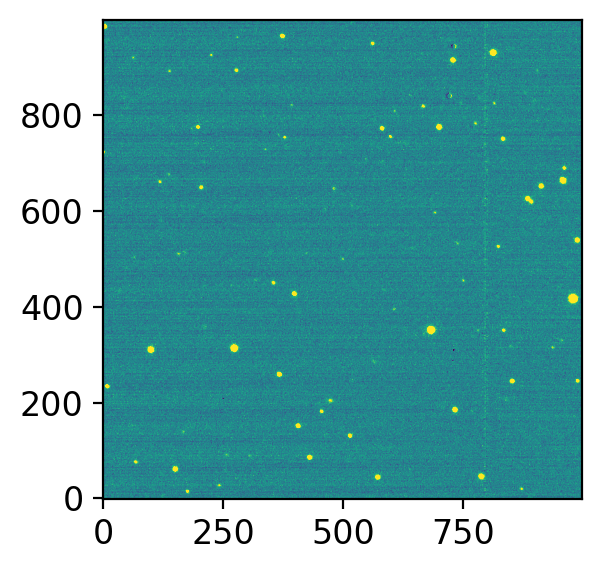

In [17]:
hdul = fits.open(allfits[0])

fig, axs = plt.subplots(1, 1, figsize=(4, 3), sharex=False, sharey=False, gridspec_kw=None)
vis.norm_imshow(axs, hdul[0].data, zscale=True)
plt.tight_layout()

This itself is of course inferior to ``ds9`` and ``ginga``, because we cannot do much interactive works.

```{tip} 
:class: tip
If you want to use interactive Jupyter, do ``%matplotlib notebook`` or ``%matplotlib widget`` for Jypyter notebook and Jupyter-lab, respectively. Search for the Internet for details.
```

## Making New FITS and Saving

Consider, for some reason, you cropped the data and take a square-root, and want to save this as a FITS file. There are few ways to do this:
1. The most primitive way is to use python indexing to select some region, convert it to `astropy.fits.PrimaryHDU` object and save it.
2. A better way is to use some pre-made functions. 
    1. Such as `astropy.nddata.CutOut2D`. Unfortunately, however, they do not automatically update header.
    2. 

### Using Numpy Slicing

(100, 100)


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_20085/2916193753.py:3: RuntimeWarning: invalid value encountered in sqrt
  newdata = np.sqrt(data[300:400, 650:750])


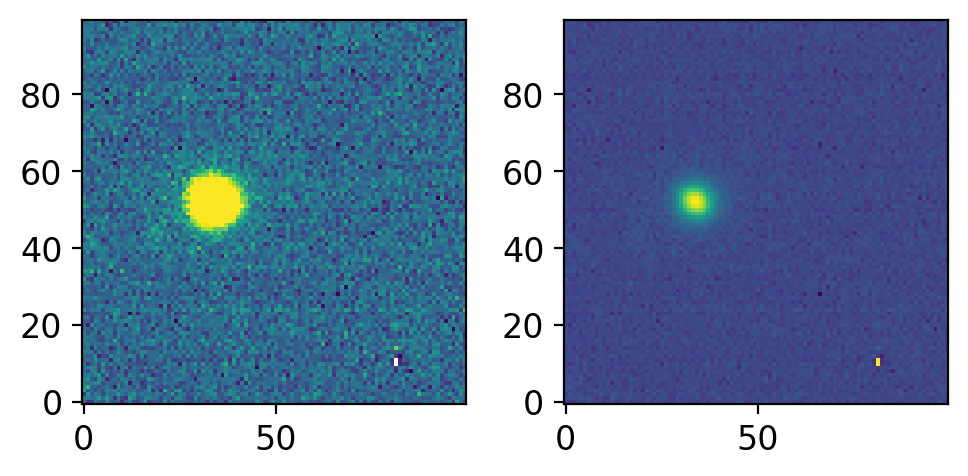

In [58]:
hdul = fits.open(allfits[0])
data = hdul[0].data
newdata = np.sqrt(data[300:400, 650:750])
print(newdata.shape)

fig, axs = plt.subplots(1, 2, figsize=(5, 3), sharex=False, sharey=False, gridspec_kw=None)
vis.norm_imshow(axs[0], newdata, zscale=True)
vis.norm_imshow(axs[1], newdata, zscale=False, stretch='sqrt')

plt.tight_layout()

Note that ``[300:400, 650:750]`` will select 100x100 pixels.

Once you are happy, you can save it by the following code:

In [13]:
newhdu = fits.PrimaryHDU(data=newdata, header=hdul[0].header)
newhdu.writeto(Path("tmp") / "test.fits", overwrite=True, output_verify='fix')

For the options when writing with `.writeto`, refer to [the official document](https://astropy.readthedocs.io/en/stable/io/fits/api/files.html#astropy.io.fits.writeto)).

```{admonition} Notes on Python numpy axis
:class: dropdown, tip
Python array has the axis orientation shown below. 
* Example: ``(x, y) = (2, 3)`` in ``data`` (the pixel at 2nd column 3rd row)  must be accessed by ``data[2, 1]`` (xy swapped, decrease by 1)
* Python slice contains the beginning index, but excludes the last index (``data[:3, 0]`` will result in ``[data[0, 0], data[1, 0], data[2, 0]]``, but **NOT** ``data[3, 0]``). Therefore, ``(x, y) = (2~3, 4~7)`` (the 2 x 4 pixels at 2nd-3rd columns & 4th-7th rows) must be accessed by ``data[3:7, 1:3]``. 
* **TIP**: So you may reach a general formula. To select ``(x, y) = (x1~x2, y1~y2)``, you have to use ``data[y1-1:y2, x1-1:x2]``.


![](https://fgnt.github.io/python_crashkurs_doc/_images/numpy_array_t.png)
▲ Note the axes order and indexing for 2-D array
```


### Using `astropy.nddata.Cutout2D`
Tutorials on this module can be found at the official documentation on [image utilities](https://docs.astropy.org/en/stable/nddata/utils.html). Also [the official doc](https://docs.astropy.org/en/stable/api/astropy.nddata.Cutout2D.html). 

```python
class astropy.nddata.Cutout2D(
    data, position, size, wcs=None, mode='trim', fill_value=nan, copy=False
)
```

`Cutout2D` is not easy to deal with --- it is not a `CCDData` nor `HDU`-like type. Thus, I made a simple function to convert it to `CCDData`.

(100, 100)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_20085/2677194592.py:28: RuntimeWarning: invalid value encountered in sqrt
  cut.data = np.sqrt(cut.data)


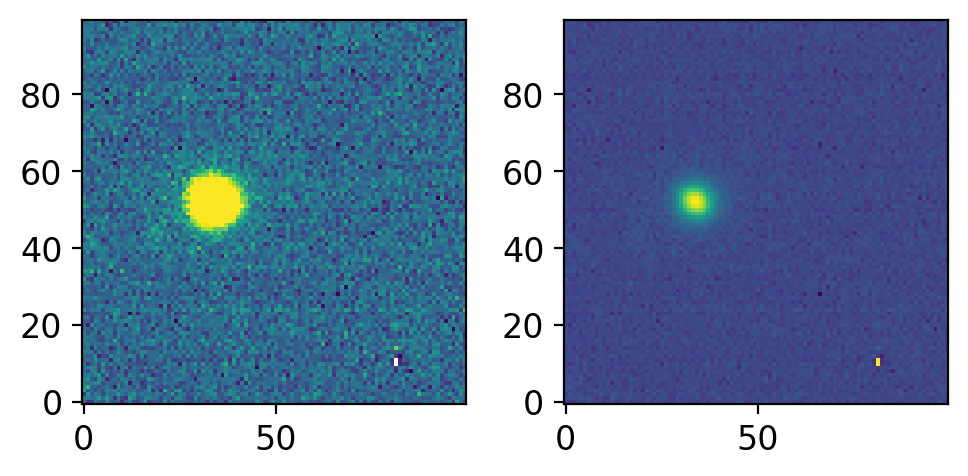

In [57]:
from astropy.nddata import Cutout2D
from astropy.wcs import WCS


def cut_ccd(ccd, position, size, mode="trim", fill_value=np.nan, warnings=True):
    """ Converts the Cutout2D object to proper CCDData."""
    cutout = Cutout2D(
        data=ccd.data, position=position, size=size,
        wcs=getattr(ccd, "wcs", WCS(ccd.header)),
        mode=mode, fill_value=fill_value, copy=True,
    )
    # Copy True just to avoid any contamination to the original ccd.

    nccd = CCDData(data=cutout.data, header=ccd.header.copy(),
                   wcs=cutout.wcs, unit=ccd.unit)
    ny, nx = nccd.data.shape
    nccd.header["NAXIS1"] = nx
    nccd.header["NAXIS2"] = ny
    nccd.header["LTV1"] = nccd.header.get("LTV1", 0) - cutout.origin_original[0]
    nccd.header["LTV2"] = nccd.header.get("LTV2", 0) - cutout.origin_original[1]

    return nccd


ccd = CCDData.read(allfits[0])
cut = cut_ccd(ccd, position=(700, 350), size=(100, 100))
print(cut.shape)
cut.data = np.sqrt(cut.data)

fig, axs = plt.subplots(1, 2, figsize=(5, 3), sharex=False, sharey=False, gridspec_kw=None)
vis.norm_imshow(axs[0], cut.data, zscale=True)
vis.norm_imshow(axs[1], cut.data, zscale=False, stretch='sqrt')
plt.tight_layout()

Because `cut` is now `CCDData`, you may use `.write` method:

In [35]:
cut.write(Path("tmp") / "test.fits", overwrite=True, output_verify='fix')

### IRAF-like Slicing
In IRAF, there is a task named [``IMCOPY``](https://iraf.readthedocs.io/en/latest/tasks/images/imutil/imcopy.html).

I made two similar functions:

```python
ysfitsutilpy.imslice(ccd, trimsec, fill_value=None, order_xyz=True,
                     update_header=True, verbose=False)
```

and 

```python
ysfitsutilpy.imcopy(inputs, trimsecs=None, outputs=None, extension=None,
                    return_ccd=True, dtype=None, update_header=True, **kwargs)
```

``imslice`` is the most basic, pythonic way of slicing a part of %he image based on ``trimsec``. ``trimsec`` can be one of

* `str`: The FITS convention section to trim (e.g., IRAF TRIMSEC).
* `[list of] int`: The number of pixels to trim from the edge of the image (bezel). If list, it must be [bezel_lower, bezel_upper].
* `[list of] slice`: The slice of each axis (`slice(start, stop, step)`)

``imcopy`` is basically a copycat of IRAF, and it uses ``imslice`` under the hood, so you may just stick to ``imslice`` unless you have specific reasons. It accepts the [list of] file name[s] or CCDData.

(100, 100)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_20085/1339730229.py:4: RuntimeWarning: invalid value encountered in sqrt
  cut.data = np.sqrt(cut.data)


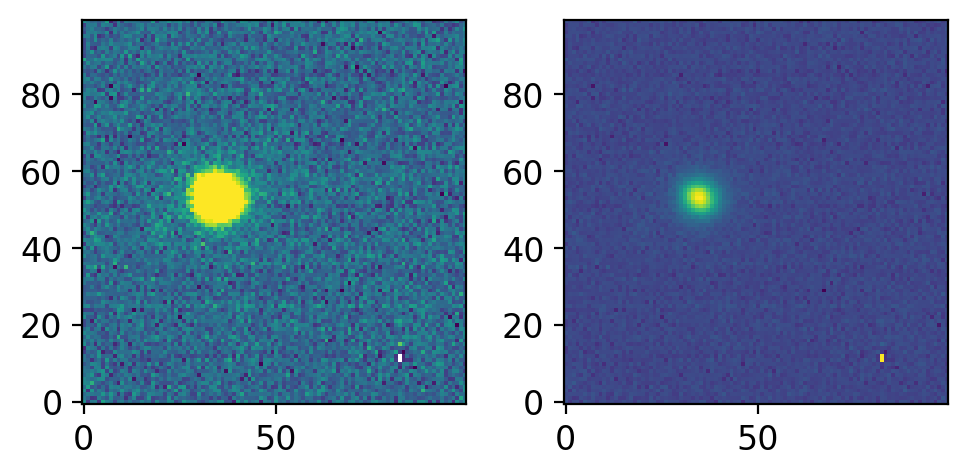

In [66]:
ccd = CCDData.read(allfits[0])
cut = yfu.imslice(ccd, trimsec="[650:749, 300:399]")
print(cut.shape)
cut.data = np.sqrt(cut.data)

fig, axs = plt.subplots(1, 2, figsize=(5, 3), sharex=False, sharey=False, gridspec_kw=None)
vis.norm_imshow(axs[0], cut.data, zscale=True)
vis.norm_imshow(axs[1], cut.data, zscale=False, stretch='sqrt')
plt.tight_layout()

Note than you had to use 749 and 399 instead of 750 and 400. This is because the traditional FITS section (IRAF section) is 1-indexing, and includes the last number. For example, to select the first pixel, python would use ``[0:1, 0:1]`` while traditional IRAF would use ``[1:1, 1:1]``.

There is a tool to convert IRAF-like section into python, but not the inverse.

In [73]:
import astro_ndslice as nds
arr2d = np.arange(100).reshape(10,10)
a_slice = nds.slice_from_string('[1:3, 1:4]', fits_convention=True)
arr2d[a_slice]

array([[ 0,  1,  2],
       [10, 11, 12],
       [20, 21, 22],
       [30, 31, 32]])

In [75]:
a_slice = nds.slice_from_string('[1:10:2, 1:4]', fits_convention=True)
arr2d[a_slice]

array([[ 0,  2,  4,  6,  8],
       [10, 12, 14, 16, 18],
       [20, 22, 24, 26, 28],
       [30, 32, 34, 36, 38]])